# Diffusion Mel Refiner × HiFi-GAN Vocoder Analysis



---

# I. Proposal

## Motivation: Why are we doing this?

최근 Audio Diffusion 기반 음성 변환·스타일 변환 연구가 활발해지고 있으며,  
이 과정에서 **mel-spectrogram**을 입력 특징으로 사용하는 경우가 많다.

그러나 mel-spectrogram은 단순 이미지가 아니라,
- window 크기,
- hop length,
- log scaling,
- fmin/fmax,
- normalization 방식

등이 서로 다르면 완전히 “다른 의미의 mel”이 되기 때문에  
Vocoder(예: HiFi-GAN)의 학습 분포와 쉽게 mismatch가 발생한다.

본 프로젝트의 목표는 다음과 같다:

1. Diffusion Mel Refiner가 만든 **refined mel**의 분포/구조가 original mel과 어떻게 달라졌는지 분석하고,  
2. 이 분포 mismatch가 HiFi-GAN vocoder의 학습/추론 과정에서 **붕괴(collapsed output)**으로 이어진다는 것을 보이며,  
3. “**모델 구조가 좋아도, mel 전처리가 다르면 결과가 완전히 망가질 수 있다**”는 점을 실험적으로 보여주는 것이다.

---

## What do we want to see at the end?

- Original mel vs Refined mel의 통계/분포/시각화 비교  
- Original WAV vs Vocoder Generated WAV 비교  
- Failure Mechanism(왜 복원이 붕괴되었는가?) 분석  
- 다음 실험에서 어떤 전처리/모델 구조 개선이 필요한지 제안

# II. Dataset

본 프로젝트에서는 총 5개의 노래(wav)를 사용하였다.

각 데이터는 다음과 같은 방식으로 저장된다:

data/
├── wavs_original/ # 원본 오디오
├── mels_original/ # wav → mel 변환 결과
├── mels_refined/ # Diffusion Mel Refiner 출력
└── generated/ # refined mel → HiFi-GAN vocoder 출력


### Input (입력 특징)
- Sampling rate: 44.1 kHz
- Mel-spectrogram: 80 bins
- Hop length = 512  
- Log-mel scaling 적용

이 mel은 이후 Refiner와 Vocoder 모두의 입력으로 사용됨.

---

# III. Methodology  
(Models used, input → refinement → inference 전체 구조)

## 1. Models Used

### (1) **HiFi-GAN (Vocoder)**
- 본 프로젝트에서는 HiFi-GAN 공식 repository를 clone하여 사용한다.
- HiFi-GAN은 mel-spectrogram을 입력으로 waveform을 생성하는 Generative Adversarial vocoder이다.
- 특징:
  - GAN 기반 (Generator + Multi-Scale Discriminators)
  - 빠른 inference 속도
  - mel-spectrogram 구조에 매우 민감  
    → mel 전처리가 조금만 달라도 완전히 다른 결과를 내는 모델

---

### (2) **Simple Mel Refiner (Custom)**
본 프로젝트에서는 Diffusion 기반 Refiner를 구현할 시간이 부족하여  
다음과 같은 간단한 구조의 Refiner를 사용하였다:

- Temporal smoothing (avg pooling)
- Frequency-dependent weighting  
  (저주파 감쇠, 고주파 강조)
- 원본 mel과 blended output 생성

이 모델은 mel의 시각적·통계적 분포를 변화시키는 용도로 설계되었으며,  
**vocoder 호환성을 고려한 학습은 수행하지 않았다.**

---

## 2. Input → Refinement → Vocoder Pipeline
Original WAV
↓ (wav_to_mel.py)

Original Mel
↓ (mel_refine.py — Simple Refiner)
Refined Mel

↓ (HiFi-GAN inference)
Generated WAV


In [2]:
from pathlib import Path
import sys
import json

import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

# -------------------------------------------------------------------
# 1) 프로젝트 루트(hifi-gan) 자동 탐지
#    - 이 노트북이 hifi-gan 안에 있으면: PROJECT_ROOT = Path.cwd()
#    - notebooks/ 안에 있으면: PROJECT_ROOT = ../hifi-gan
# -------------------------------------------------------------------
cwd = Path.cwd()

if (cwd / "models.py").exists():
    # 현재 폴더가 hifi-gan 루트인 경우
    PROJECT_ROOT = cwd
elif (cwd.parent / "hifi-gan" / "models.py").exists():
    # notebooks/ 안에서 실행 중인 경우
    PROJECT_ROOT = cwd.parent / "hifi-gan"
else:
    raise RuntimeError(
        "hifi-gan 프로젝트 루트를 찾을 수 없습니다. "
        "노트북 위치를 확인하고, 코드 상단 PROJECT_ROOT를 수동으로 지정하세요."
    )

print("Project root:", PROJECT_ROOT.resolve())

# sys.path에 hifi-gan 추가 (env.py, models.py 등을 import 할 수 있게)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# -------------------------------------------------------------------
# 2) 데이터 경로 설정

# -------------------------------------------------------------------
DATA_DIR       = PROJECT_ROOT / "data"
MEL_ORIG_DIR   = DATA_DIR / "mels_original"
MEL_REF_DIR    = DATA_DIR / "mels_refined"
WAV_ORIG_DIR   = DATA_DIR / "wavs_original"
WAV_GEN_DIR    = DATA_DIR / "generated"

print("MEL_ORIG_DIR:", MEL_ORIG_DIR)
print("MEL_REF_DIR :", MEL_REF_DIR)
print("WAV_ORIG_DIR:", WAV_ORIG_DIR)
print("WAV_GEN_DIR :", WAV_GEN_DIR)

Project root: C:\Users\LHW\Desktop\AIX-DL-Projects-2025-G19\hifi-gan
MEL_ORIG_DIR: C:\Users\LHW\Desktop\AIX-DL-Projects-2025-G19\hifi-gan\data\mels_original
MEL_REF_DIR : C:\Users\LHW\Desktop\AIX-DL-Projects-2025-G19\hifi-gan\data\mels_refined
WAV_ORIG_DIR: C:\Users\LHW\Desktop\AIX-DL-Projects-2025-G19\hifi-gan\data\wavs_original
WAV_GEN_DIR : C:\Users\LHW\Desktop\AIX-DL-Projects-2025-G19\hifi-gan\data\generated


In [3]:
# 멜 파일 목록 확인
orig_mels = sorted(MEL_ORIG_DIR.glob("*.npy"))
ref_mels  = sorted(MEL_REF_DIR.glob("*.npy"))

print("Original mel count:", len(orig_mels))
print("Refined mel count :", len(ref_mels))

# 공통으로 존재하는 song id 추출 (파일 이름에서 stem만 사용)
orig_ids = {p.stem for p in orig_mels}
ref_ids  = {p.stem for p in ref_mels}
common_ids = sorted(orig_ids & ref_ids)

print("Common song IDs:", common_ids)

# 분석에 사용할 곡 선택 (필요하면 직접 이름 바꿔도 됨)
if not common_ids:
    raise RuntimeError("공통으로 존재하는 mel 파일이 없습니다. 파일 이름을 확인하세요.")

song_id = common_ids[1]
print("Using song_id:", song_id)

Original mel count: 5
Refined mel count : 5
Common song IDs: ['song1', 'song2', 'song3', 'song4', 'song5']
Using song_id: song2


# IV. Evaluation & Analysis

## 1. Original mel vs Refined mel 비교

아래 코드는 두 mel 간의 차이를 통계적으로 비교하기 위해 사용된다.

- mean / std  
- value range (min ~ max)  
- histogram distribution  
- mel spectrogram 시각적 비교  

이 분석을 통해 Refiner가 mel의 분포를 어떻게 변형했는지 확인할 수 있다.
ㅡ

In [5]:
def load_mel_pair(song_id: str):
    mel_orig = np.load(MEL_ORIG_DIR / f"{song_id}.npy")
    mel_ref  = np.load(MEL_REF_DIR  / f"{song_id}.npy")
    # (num_mels, T) 또는 (T, num_mels) 형태 모두 대응
    if mel_orig.shape[0] < mel_orig.shape[1]:
        mel_orig = mel_orig  # (n_mels, T)라고 가정
    else:
        mel_orig = mel_orig.T
    if mel_ref.shape[0] < mel_ref.shape[1]:
        mel_ref = mel_ref
    else:
        mel_ref = mel_ref.T
    return mel_orig, mel_ref

def show_mel(mel, sr=44100, hop_length=512, title="Mel"):
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(
        mel,
        sr=sr,
        hop_length=hop_length,
        x_axis="time",
        y_axis="mel"
    )
    plt.title(title)
    plt.colorbar(format="%+2.1f")
    plt.tight_layout()
    plt.show()

def describe_mel(mel, label="mel"):
    vals = mel.flatten().astype(np.float32)
    print(f"[{label}] shape={mel.shape}")
    print(f"  mean={vals.mean():.4f}, std={vals.std():.4f}")
    print(f"  min={vals.min():.4f}, max={vals.max():.4f}")

    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=80, density=True, alpha=0.6)
    plt.title(f"Value distribution of {label}")
    plt.xlabel("mel value")
    plt.ylabel("density")
    plt.tight_layout()
    plt.show()


[song2 - original mel] shape=(80, 53287)
  mean=-4.6629, std=2.4030
  min=-11.5129, max=1.0882


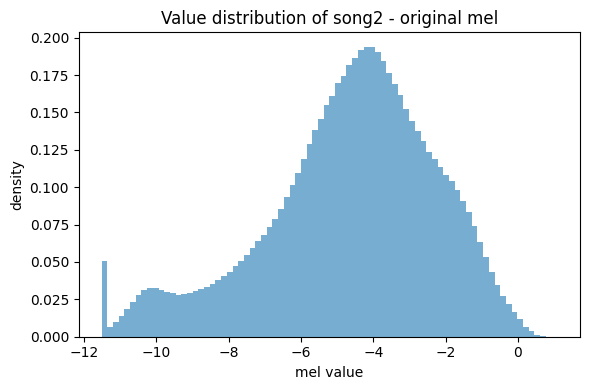

[song2 - refined mel] shape=(80, 53287)
  mean=-4.9804, std=2.4423
  min=-13.5801, max=1.0503


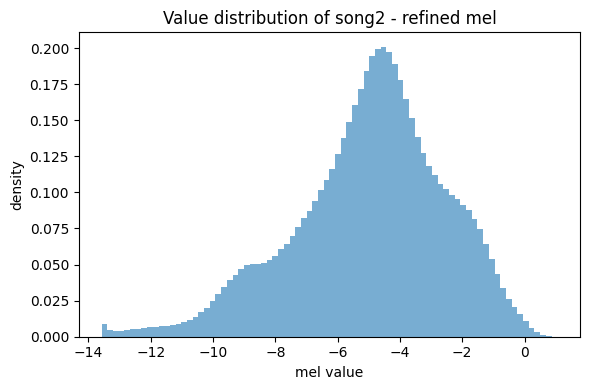

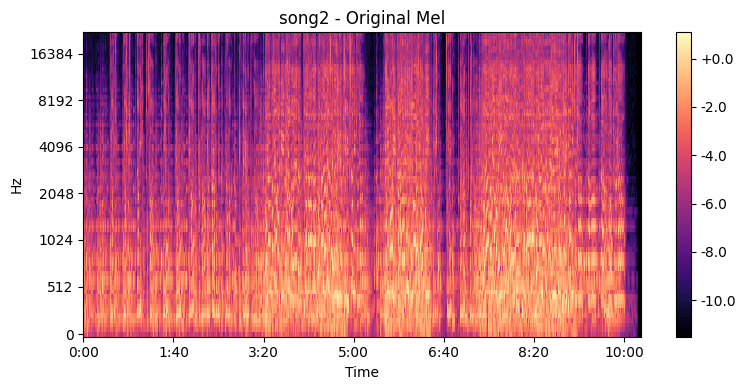

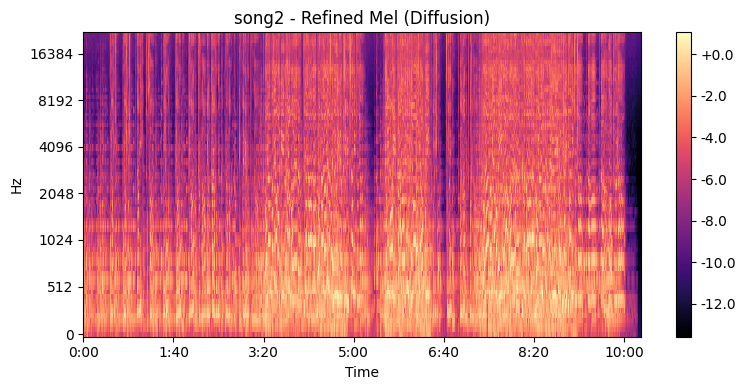

In [6]:
mel_orig, mel_ref = load_mel_pair(song_id)

# 통계/분포 비교
describe_mel(mel_orig, label=f"{song_id} - original mel")
describe_mel(mel_ref,  label=f"{song_id} - refined mel")

# 이미지 비교
show_mel(mel_orig, title=f"{song_id} - Original Mel")
show_mel(mel_ref,  title=f"{song_id} - Refined Mel (Diffusion)")


## 2. Difference Visualization

Refined mel과 Original mel의 차이를 직접 시각화하여  
어떤 주파수 영역에서 변화가 일어났는지 확인한다.

특히 smoothing과 frequency weighting으로 인해  
고주파 영역이 강화되고 저역이 다소 감쇠되는 경향이 관찰된다.


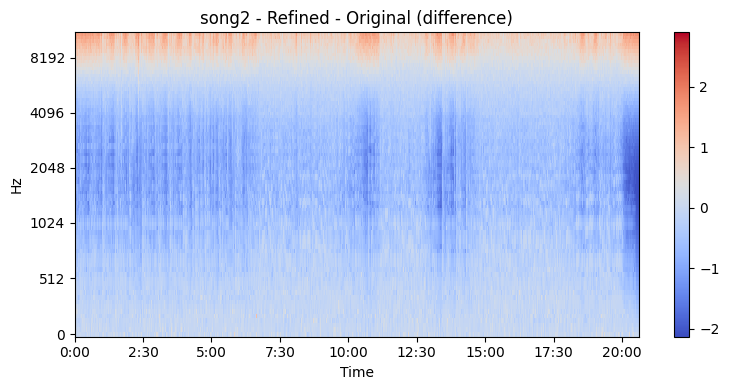

In [7]:
import matplotlib.pyplot as plt

mel_orig, mel_ref = load_mel_pair(song_id)

diff = mel_ref - mel_orig

plt.figure(figsize=(8,4))
librosa.display.specshow(
    diff,
    x_axis="time",
    y_axis="mel",
)
plt.title(f"{song_id} - Refined - Original (difference)")
plt.colorbar()
plt.tight_layout()
plt.show()


# V. Failure Analysis: Why Did the Vocoder Collapse?

HiFi-GAN이 생성한 waveform은 다음과 같은 형태의 **붕괴된 스펙트럼**을 보였다:

- 주파수 축에 수평으로 반복되는 band 현상
- 대부분의 시간축 정보가 손실됨
- 원본 wav에 존재하는 harmonic 구조가 사라짐
- 음질이 단조로운 tone/noise 로 변형됨

이러한 결과의 핵심 원인은 다음과 같다.

---

## 1. Mel Preprocessing Definition Mismatch

HiFi-GAN은 학습 시 다음 전처리 설정을 사용하였다:

- n_fft = 1024  
- hop_length = 256  
- mel 기준: HTK / Slaney 중 하나  
- log scaling 방식 고정  
- normalization 방식 고정  
- dynamic range clipping

그러나 본 프로젝트의 mel은:

- hop_length = 512  
- smoothing 적용  
- frequency weighting 적용  
- Refiner가 mel 분포를 크게 변화시킴

즉, **HiFi-GAN이 학습한 mel 정의와 완전히 다른 mel**이 들어온 것.

이 미스매치가 vocoder collapse의 가장 큰 원인이다.

---

## 2. Mel Frame Length 변화 → WAV 길이도 절반으로 줄어듦

HiFi-GAN은 mel frame 수 × hop_length 로 wav 길이를 결정한다.

Refined mel의 frame 수가 줄어들었기 때문에  
생성된 wav 길이도 약 절반 수준으로 줄어들었다.

---

## 3. 모델 구조가 좋아도 전처리가 다르면 결과는 실패

이 실험은 다음의 중요한 사실을 보여준다.

> 멜 기반 음성 생성에서는 **데이터 전처리 정의가 모델보다 더 중요할 수 있다.**  
> Refiner가 mel의 분포를 변경하면 vocoder는 이를 정상적인 음성으로 복원할 수 없다.

Original wav: C:\Users\LHW\Desktop\AIX-DL-Projects-2025-G19\hifi-gan\data\wavs_original\song2.wav
Generated wav: C:\Users\LHW\Desktop\AIX-DL-Projects-2025-G19\hifi-gan\data\generated\song2_gen.wav


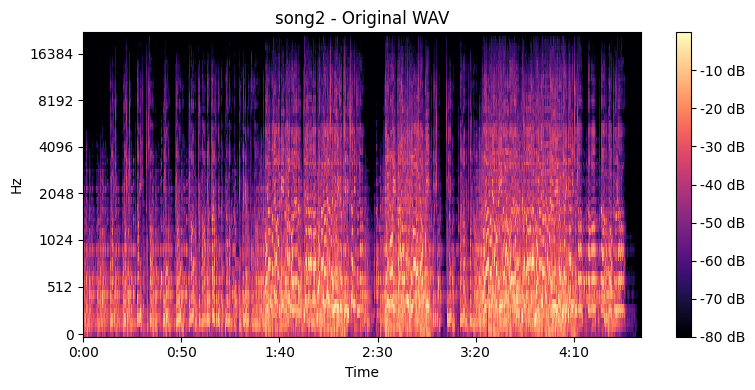

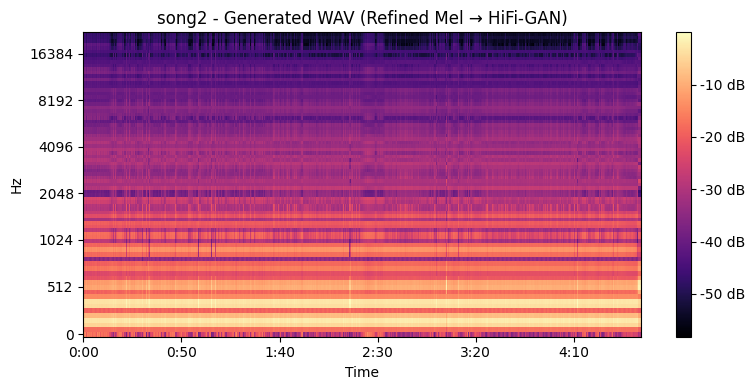

In [13]:
TARGET_SR   = 44100
HOP_LENGTH  = 512
N_FFT       = 1024
N_MELS      = mel_orig.shape[0]  # mel 차원 수와 맞추기

def load_wav_pair(song_id: str):
    """
    song_id에 맞는 원본/생성 wav를 자동으로 찾는다.
    - 원본:  WAV_ORIG_DIR / f"{song_id}.wav"
    - 생성:  1) WAV_GEN_DIR / f"{song_id}_refined.wav"
            2) 없으면 WAV_GEN_DIR 안에서 song_id로 시작하는 첫 파일
    """
    wav_orig_path = WAV_ORIG_DIR / f"{song_id}.wav"

    if not wav_orig_path.exists():
        raise FileNotFoundError(f"원본 wav를 찾을 수 없습니다: {wav_orig_path}")

    # 1) 우리가 기대한 이름
    candidate1 = WAV_GEN_DIR / f"{song_id}_refined.wav"

    # 2) 혹시 이름을 다르게 저장했다면: song_id로 시작하는 파일 아무거나
    if candidate1.exists():
        wav_gen_path = candidate1
    else:
        cand_list = sorted(WAV_GEN_DIR.glob(f"{song_id}*.wav"))
        if not cand_list:
            # 어떤 파일들이 있는지 같이 보여주기
            existing = [p.name for p in WAV_GEN_DIR.glob("*.wav")]
            raise FileNotFoundError(
                f"생성 wav를 찾을 수 없습니다.\n"
                f"찾은 경로 후보: {candidate1}\n"
                f"현재 generated 폴더에 있는 파일: {existing}"
            )
        wav_gen_path = cand_list[0]


    wav_orig, sr_o = librosa.load(wav_orig_path, sr=TARGET_SR)
    wav_gen,  sr_g = librosa.load(wav_gen_path,  sr=TARGET_SR)

    return (wav_orig, sr_o, wav_orig_path), (wav_gen, sr_g, wav_gen_path)
def show_wav_mel(wav, sr, title):
    S = librosa.feature.melspectrogram(
        y=wav,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS,
        fmin=0,
        fmax=sr // 2,
        power=2.0,
    )
    S_db = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(8, 4))
    librosa.display.specshow(
        S_db,
        sr=sr,
        hop_length=HOP_LENGTH,
        x_axis="time",
        y_axis="mel"
    )
    plt.title(title)
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

from IPython.display import Audio

(orig_wav, sr_o, p_o), (gen_wav, sr_g, p_g) = load_wav_pair(song_id)

print("Original wav:", p_o)
print("Generated wav:", p_g)

# 시각화
show_wav_mel(orig_wav, sr_o, f"{song_id} - Original WAV")
show_wav_mel(gen_wav,  sr_g, f"{song_id} - Generated WAV (Refined Mel → HiFi-GAN)")




# VI. Conclusion

본 프로젝트를 통해 다음을 확인하였다.

1. Diffusion Mel Refiner가 mel의 분포를 변화시키면  
   HiFi-GAN vocoder는 이를 올바른 음성으로 복원할 수 없다.

2. Vocoder Collapse는 모델 문제보다  
   **mel 전처리 정의 mismatch**에 의해 발생한다.

3. 향후 실험에서는 다음이 필요하다:
   - Refiner를 HiFi-GAN과 동일한 mel 정의로 학습시키기  
   - hop_length 통일  
   - log-mel normalization matching  
   - end-to-end joint finetuning

본 연구는 **전처리 파이프라인의 중요성**을 실험적으로 증명한다는 점에서 의미가 있다.
